<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>

<h1>HELP</h1>

Machine learning for uncovering inisight in your business and market

In [4]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
import numpy as np
from pymongo import MongoClient
import nltk
import re

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2

HTML("""
<style>
// add your CSS styling here
</style>
""")
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

<h1 class='main_header'>Topic Modeling</h1>
<hr>

Within machine learning and natural language processing, a *topic model* is a type of statistical model for discovering abstract topics, or groups, that occur in a collection of documents. These topics are latent structures of the documents. The premise behind most of these models is that certain words will be more frequent in certain topics. For example, a document about sports is likly to contain the words "touchdown" and "runner", while a document about mathematics is much less likly to contain these words.

For the Yelp data we will use this genre of model in several ways:
 - Grouping similar reviews for a business
 - Finding similar business competitors
 - Discovering importatntant trends in reviews

<h2 class="section_header">Review Clustering</h2>

First, we will discover "documents" in the reviews. This can be interpreted as the different subjects and types of reviews users leave. Uncovering this latent structure could help a business see the categories that stand out to customers, for better of worse.

In [2]:
# Select a well know business
BIZ_ID = 'eAc9Vd6loOgRQolMXQt6FA'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


In [3]:
# Make a list of reviews and stars
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

In [10]:
print review_list[9]

Rum Jungle is a pretty amazing bar. Worth stopping by in the afternoon just to sit in and look at the decor and fountains. Glad I went.


In [12]:
# Tokenize those reviews so they can be processed
print tokenize(review_list[9]) 

[u'rum', u'jungle', u'is', u'a', u'pretty', u'amazing', u'bar', u'worth', u'stopping', u'by', u'in', u'the', u'afternoon', u'just', u'to', u'sit', u'in', u'and', u'look', u'at', u'the', u'decor', u'and', u'fountains', u'glad', u'i', u'went']


## Term Frequency-Inverse Document Frequency (Tf-idf)

After cleaning and tokenizing the text from reviews we can create teh term frequencey-inverse document frequency matrix.  This matrix counts the occurences of every important word in every document. Then like the picture bellow it stacks these vectors so the it is one matrix with the dimension (NUM_DOCUMENTS X VOCAB_SIZE).

<img src='nb_images/tf-idf.png'>

Once this matrix is created we then weight the words that occur frequently in the document but not in the corpus higher.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [14]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(review_list)
vocab_list = tfidf_vectorizer.get_feature_names()

In [15]:
print(tfidf_matrix.shape)

(2305, 104)


From this we can see that we have 2305 reviews (aka documents) and a vocab size of 104. Now we can use this matrix to determine the distance between them in the 104 dimensional document space. The metric we will use for this is cosine similarity.

In [16]:
dist = 1 - cosine_similarity(tfidf_matrix)

## Clustering Documents

In [17]:
NUM_CLUSTERS = 4
k_means = KMeans(NUM_CLUSTERS)
k_means.fit(tfidf_matrix)
labels = np.array(k_means.labels_.tolist())

In [20]:
for i in range(NUM_CLUSTERS):
    print "Cluster %d: " % i
    print "-"*25
    print "Top Words: ",
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
    for ind in order_centroids[i,:6]:
        print vocab_list[ind] + ", ",
    print "\nNumber of Reviews: %d" % np.sum(labels == i)
    print "Avg Stars: %.2f" % np.mean(star_list[labels == i])
    print "\n"

Cluster 0: 
-------------------------
Top Words:  room,  hotel,  check,  stay,  service,  time,  
Number of Reviews: 737
Avg Stars: 2.64


Cluster 1: 
-------------------------
Top Words:  pool,  lazy,  river,  lazy river,  wave,  wave pool,  
Number of Reviews: 309
Avg Stars: 3.86


Cluster 2: 
-------------------------
Top Words:  mandalay,  bay,  mandalay bay,  hotel,  room,  stay,  
Number of Reviews: 452
Avg Stars: 3.40


Cluster 3: 
-------------------------
Top Words:  hotel,  great,  place,  nice,  casino,  rooms,  
Number of Reviews: 807
Avg Stars: 3.64




##  Visualizing Clusters

By projecting these 100 dimensional vectors to 2 dimensional space with TSNE, we are able to see the clusters

In [21]:
from sklearn.manifold import MDS, TSNE

In [28]:
mds = TSNE(n_components=2)
pos = TSNE.fit_transform(dist)

/Users/lnelson/anaconda/lib/python2.7/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


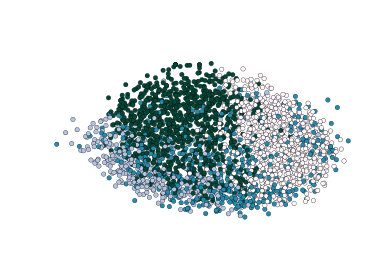

In [29]:
plt.scatter(pos[:,0], pos[:,1], c=labels, cmap=plt.cm.PuBuGn)
plt.axis('off')
plt.show()

<h2 class="section_header">Latent Dirichlet Allocation</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [32]:
from gensim import corpora, models, similarities 
import pyLDAvis.gensim

In [34]:
#preprocess
tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [35]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [36]:
lda = models.LdaModel(corpus, num_topics=7, id2word=dictionary, 
                      update_every=5, chunksize=5, passes=6)

Ater looking at the words assosiated with the different topics I was able to label these groups.

In [37]:
topic_labels = [
    'Families and Groups',
    'Rooms and Physical Aspects',
    'Entertainment and Events',
    'Customer Service',
    'Pool and Casino',
    'Resturant at Water Show',
    'Transportation'
]

In [39]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (Families and Groups)
--------------------
pool
river
beach
area
kids
wave
hotel
chairs
water
cup
place
plenty
shops
lobby
strip
drinks
lazy
line
shopping
sand

Topic 1 (Rooms and Physical Aspects)
--------------------
i
room
hotel
service
time
line
floor
bathroom
view
minutes
bed
customer
front
water
security
shower
bay
door
mandalay
star

Topic 2 (Entertainment and Events)
--------------------
i
hotel
day
resort
room
time
stay
place
night
vegas
rooms
hotels
mandalay
food
pools
staff
money
fee
everything
coffee

Topic 3 (Customer Service)
--------------------
night
bay
people
i
weekend
mandalay
hotel
suite
experience
beds
book
things
service
part
rooms
anything
years
staff
amenities
nothing

Topic 4 (Pool and Casino)
--------------------
strip
mandalay
bay
casino
hotel
it's
end
vegas
restaurants
rooms
tram
location
property
center
stars
view
shark
show
casinos
reef

Topic 5 (Resturant at Water Show)
--------------------
check
someone
business
bit
resorts
luck
anything
items
i

In [40]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

These topics perform very well in finding the latentent structure of areas of the business. One issue with this model is it is difficult to find the appropriate number of clusters for a new business.

## LDA For Multiple Businesses

Next we apply LDA to reviews from 5 different types of businesses. The goal of this is to discover these labels.

In [41]:
# Connect to database
client = MongoClient()
db = client.yelp

In [57]:
# Get examples from distinct businesses for training
different_categories = ['Automotive', 'Hair Salons', 'Pets', 'Medical Centers', 'Butcher']

category_dict = {}
for category in different_categories:
    cursor = db.businesses.find({'categories': {"$elemMatch":{"$in":[category]}}}).limit(100)
    total_reviews = []
    for business in cursor:
        biz_reviews = [x['text'] for x in get_business_reviews(business['business_id'])]
        concat_biz_review = ' '.join(biz_reviews)
        cleaned_review = get_nouns(tokenize(concat_biz_review))
        total_reviews.append(cleaned_review)
    category_dict[category] = total_reviews

In [58]:
#preprocess
tokenized_docs = []
category_labels = []
for i, category in enumerate(different_categories):
    tokenized_docs += category_dict[category]
    category_labels += [i] * len(category_dict[category])

In [ ]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=.05, no_above=0.6)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [60]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=100, passes=10)

In [61]:
lda.show_topics()

[(0,
  u'0.028*"meat" + 0.014*"food" + 0.011*"meats" + 0.011*"butcher" + 0.011*"quality" + 0.009*"beef" + 0.009*"store" + 0.008*"selection" + 0.007*"shop" + 0.007*"chicken"'),
 (1,
  u'0.049*"hair" + 0.020*"salon" + 0.013*"cut" + 0.011*"car" + 0.011*"job" + 0.010*"color" + 0.010*"appointment" + 0.008*"stylist" + 0.007*"experience" + 0.006*"haircut"'),
 (2,
  u'0.032*"hospital" + 0.020*"room" + 0.019*"nurses" + 0.018*"nurse" + 0.018*"er" + 0.018*"pain" + 0.007*"patients" + 0.005*"food" + 0.005*"der" + 0.005*"son"'),
 (3,
  u'0.015*"dr" + 0.015*"care" + 0.014*"doctor" + 0.012*"office" + 0.009*"surgery" + 0.008*"people" + 0.008*"day" + 0.008*"appointment" + 0.008*"experience" + 0.007*"minutes"'),
 (4,
  u'0.038*"dog" + 0.024*"dogs" + 0.011*"pet" + 0.010*"animals" + 0.009*"cat" + 0.009*"home" + 0.007*"store" + 0.007*"people" + 0.007*"day" + 0.006*"pets"')]

In [71]:
topic_labels = [
    'butcher',
    'hair salons',
    'medical centers',
    'automotive',
    'pets',
]

In [72]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (butcher)
--------------------
meat
food
meats
butcher
quality
beef
store
selection
shop
chicken

Topic 1 (hair salons)
--------------------
hair
salon
cut
car
job
color
appointment
stylist
experience
haircut

Topic 2 (medical centers)
--------------------
hospital
room
nurses
nurse
er
pain
patients
food
der
son

Topic 3 (automotive)
--------------------
dr
care
doctor
office
surgery
people
day
appointment
experience
minutes

Topic 4 (pets)
--------------------
dog
dogs
pet
animals
cat
home
store
people
day
pets


Now that we have discovered these topics, given reviews for a business we can give the amount it belongs to each topic.

In [74]:
accuracy = 0
for i, category in enumerate(different_categories):
    results = []
    num_category = len(category_dict[category])
    for review in category_dict[category]:
        doc_bow = dictionary.doc2bow(review)
        distribution = lda[doc_bow]
        percents = np.array([x[1] for x in distribution])
        max_indx = np.argmax(percents)
        results.append(distribution[max_indx][0])
    classes, amounts = np.unique(results, return_counts=True)
    print "Classes: %7s, Amount: %s" % (classes, amounts)

Classes: [0 1 2 3 4], Amount: [ 4 52  1 40  3]
Classes: [1 3 4], Amount: [96  1  3]
Classes: [0 1 2 3 4], Amount: [ 4  3  1 32 60]
Classes: [1 2 3 4], Amount: [ 3  3 90  4]
Classes:   [0 2], Amount: [93  7]


<h1 class='main_header'>Sentiment Analysis</h1>
<hr>

Sentiment analysis is a branch of natural language processing that aims to systematically identify, extract, and quantify affective states and subjective information. The prototypical example is classifying if a review is positive or negative. For a bisunesses Yelp reviews we will use this so we can determine what is included in the most negative and most positive reviews. This can give concise information on what needs to be fixed and what is going well.

There are several teqniques for doing this...

<h2 class='section_header'>Naive Bayes</h2>

Because of the complex nature of working with text, historically the simple naive bayes model has been the standard for sentiment anaysis. The text is read in and then transformed into a simple bag of words. This gives the probability of words ocurring given a certain sentiment which is then used by naive bayes.

$$ P(c\vert x) = \frac{P(x\vert c)P(c)}{P(x)}$$
$$ P(c\vert x) = P(x_1\vert c) \times P(x_2\vert c)\times \dots P(x_n\vert c) \times P(c)$$

In [67]:
from yelp_utils.preprocess_reviews import prepare_classify
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [68]:
# Create trainging set of positive and negative examples
pos_list, neg_list = prepare_classify(700)
train = pos_list[:500] + neg_list[:500]
test = pos_list[500:] + neg_list[500:]

In [75]:
naiveBayes = NaiveBayesClassifier(train)

KeyboardInterrupt: 

In [ ]:
naiveBayes.show_informative_features()

In [ ]:
naiveBayes.accuracy(test_set)

<h1 class='main_header'>Automatic Summary</h1>
<hr>

In [ ]:
from sumy.nlp import tokenizers
from sumy.parsers import plaintext
from sumy.summarizers import lex_rank

In [ ]:
review_list = [x['text'] for x in get_business_reviews(BIZ_ID)]

In [ ]:
concat_review = ' '.join(review_list[:100])

tokenizer = tokenizers.Tokenizer('english')    
parse = plaintext.PlaintextParser(concat_review, tokenizer)
doc = parse.document  
rank = lex_rank.LexRankSummarizer()

#Print the top ten results of the sorting
print('Ranked Sentences:')
print('------------------------------')
for i, sentence in enumerate(rank(doc, 10)):
    print('{}: {}'.format(i+1, sentence))
    print('\n')

<h1 class='main_header'>Estimating Competitive Radi</h1>
<hr>

While being able to determine what is relavent in a review enables companies to make quick and well supported decisions on what is going and what is going well, it does not offer a way for a buisness to compare itself to it's competitors, as proximity is as major a factor as functionality is. 

The goal of the section is to determine an effective way to determine the `radius of competition` for now we assume that this radius is independently determined by the city which the buisness is located (this may or may not be a good assumption). 

In [1]:
from yelp_utils.data_manager import get_all_reviews_by_user_for_city, get_average_lat_and_long, get_max_distacne_from_mid, get_radius_from_review_centers_dict

For this demonstraion we will use Henderson, Nevada (a city next to Las Vegas) to visualize our methods. 

In [2]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

## Visualizing Review Centers

In order to determine a radius from a bunch of points we will calculate the "centers" of the data points -- since our cordinates aren't close to the poles or very far from one another -- by averaging the latitudes and longitudes independently. 

It's important to note that this certainly is not the best way to deal with this type of data, a more appropriate way is detailed <a href = "http://www.geomidpoint.com/calculation.html"> here</a> however it is more complex temporally and algorithmically, so we settle for our simplified solution. 

In [7]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def visualize_locations(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def get_bad_point(reviews_dict, y_bad=-1):
    bad_points = None
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        if y > y_bad:
            bad_points = user_review
    return bad_points

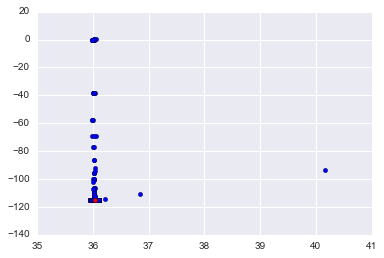

In [8]:
bad_point = get_bad_point(henderson_reviews)
visualize_locations(henderson_reviews).show()

That red dot near the 36 tick is the actual location of Henderson. 36' N 0' E (toward the top of that vertical arangement of points) is a location just north of Algeria. Over 5000 miles away! And that is the CENTER of the data! (That means that one of the points is in Asia or something!) Henderson isn't quite that big, infact Henderson is contained completely between: (35.891588, -115.218488) and (36.130405, -114.914276).

This is obviously and issue as some of the reviews radius will be over 5000 miles! Surely a bikeshop in Henderson can't view a bikeshop in Connecticut as a competitor! That is outragous. 

In [9]:
bad_point

[(36.019323, 115.086769), (35.9658025616, -115.169019763)]

It appears as though our data is missing signs randomly. Unfortunately checking if a point is in a city is non trivial, so we cannot simply look for places which signs should change. Instead we will combat this by methods below. 

## Dealing with Outliers

### Naive K means Outlier Removal
This approach, while Naive, emperically at least leaves a center which is far more reasonable. 

In [10]:
def get_clusters(data, n_clusters=2):
    kmeans = KMeans(n_clusters=2).fit(data)
    centers = kmeans.cluster_centers_
    to_return = [[] for i in range(len(centers))]
    for x in data:
        dist = np.linalg.norm(centers - x, 1, axis=1)
        index = np.argmin(dist)
        to_return[index].append(x)
    #Below we make the assumption that the most points are found in a given city at least!
    return sorted([np.vstack(i) for i in to_return], key=lambda x: len(x))[::-1]

In [11]:
def clean_reviewer_average_radius_with_get_clusters(reviews):
    good_points = {}
    for i, dict_pair in enumerate(reviews.iteritems()):
        key, val = dict_pair
        if len(val) > 1:
            dis_from_mid = get_max_distacne_from_mid(val)
            k = 2
            while dis_from_mid > 100: #cities are never bigger than 100 miles in diameter
                val = get_clusters(val, n_clusters=k)[0] #select the data with the most points
                k += 1
                dis_from_mid = get_max_distacne_from_mid(val)
            good_points[key] = val
    return good_points

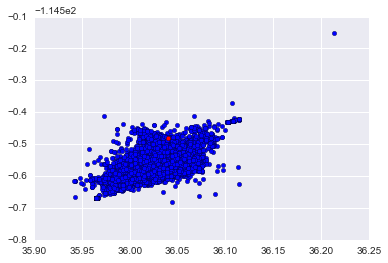

In [14]:
kmeans_cleaned = clean_reviewer_average_radius_with_get_clusters(henderson_reviews)
visualize_locations(kmeans_cleaned).show()

As you can see these centers make much more sense. At very least all except one point is found in city boundries.

### EllipticEnvelope


SKlearn suggests using the default value for the `support_fraction` parameter, so we will (this gives the purple boundry)

For more disscussion on the workings of this method see: http://www.geo.upm.es/postgrado/CarlosLopez/papers/FastAlgMCD99.pdf

The algorithm used is NOT an EM algorithm, but rather a MM algorithm (Majorize-Minimization). To read more specifics about it's innner workings also check out: https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf

In [17]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

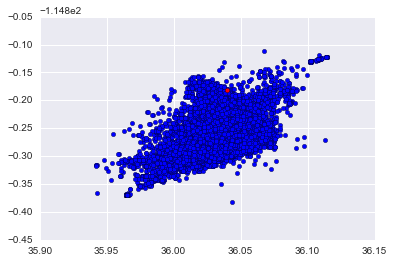

In [18]:
EllipticEnvelope_cleaned = clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)
visualize_locations(EllipticEnvelope_cleaned).show()

These results are even better than the previous ones! All of these points are within hendersons city limits. 

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more than emperical, there is some hard mathematics that has been developed regarding the statistics behind this method


### Random Forest for Anomaly Detection (Isolation Forest)

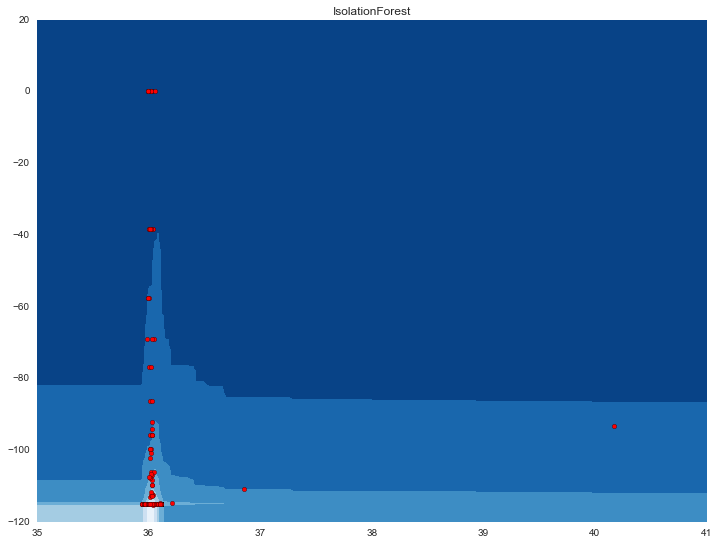

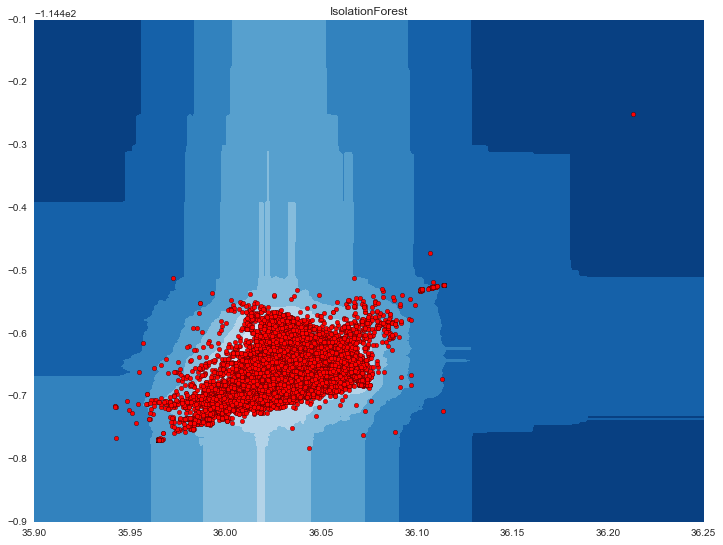

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

plt.figure(figsize=(12, 9))
rng = np.random.RandomState(42)

# Generate train data
X = get_all_centers_as_array(henderson_reviews)[0]

# fit the model
clf = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
clf.fit(X)

for xx_t, yy_t in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx, yy = np.meshgrid(np.linspace(xx_t[0], xx_t[1], 250), np.linspace(yy_t[0], yy_t[1], 250))
    # plot the line, the samples, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    c = plt.scatter(X[:, 0], X[:, 1], c='red')
    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.show()

In [44]:
from sklearn.ensemble import IsolationForest
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    rng = np.random.RandomState(42)
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    des_on = classifier.decision_function(centers)
    #Within four standard deviations of the decision_function
    inlier_indexes = np.where(abs(des_on - np.mean(des_on))  < 4*np.std(des_on))
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

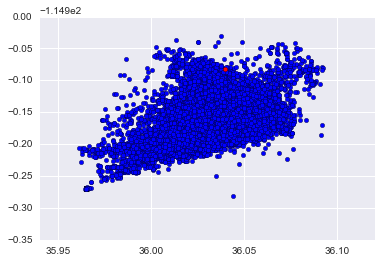

In [45]:
IsolationForest_cleaned = clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)
visualize_locations(IsolationForest_cleaned).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more very fast and parrellization comes for free with it, unlike with the EllipticEnvelope.


### Conclusion

#### Competitive Region Results
All of the methods produce pretty similar radi:

In [46]:
print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(kmeans_cleaned)))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(EllipticEnvelope_cleaned)))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(IsolationForest_cleaned)))

Naive K-Means Clusters predicted a radius of: 4.4297
Elliptic Envelope predicted a radius of: 4.3851
Isolation Forest predicted a radius of: 4.3944


#### Phoenix
For sanity that all of our learners are working properly and as expected we will now test it on a new set to make sure we are still getting reasonable results. 

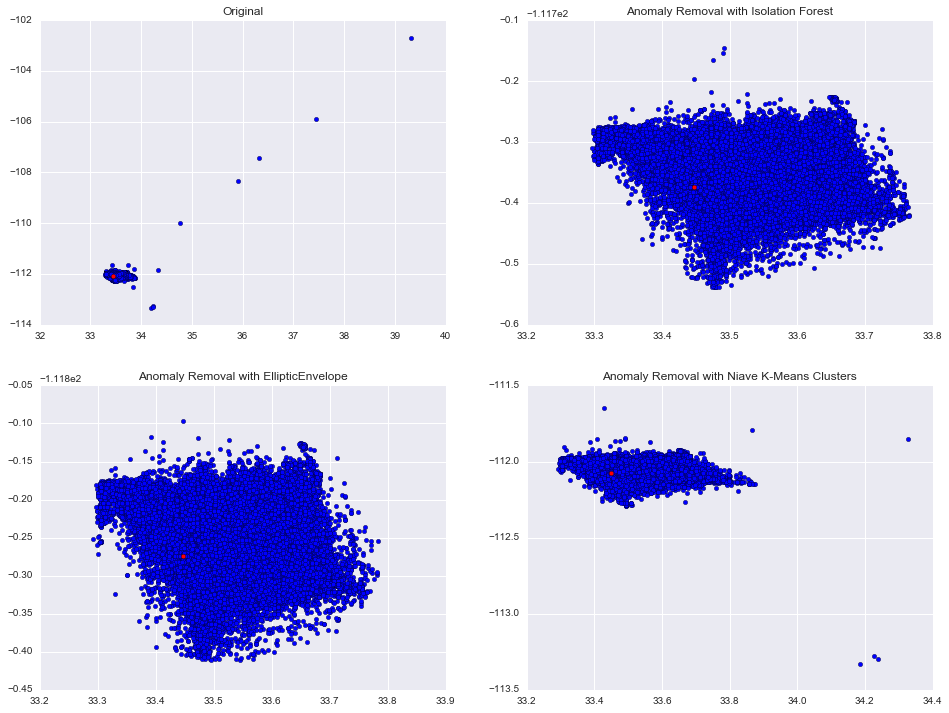

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9380


In [47]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_locations(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_locations(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))